[View in Colaboratory](https://colab.research.google.com/github/x110/MyFastaiNotebooks/blob/master/lang_model_arxiv.ipynb)

# Sentiment Classification


## Introduction

### Objective
The sentiment classification task consists of predicting the polarity (positive or negative) of a given text. 


###  Dataset
The [large moview view dataset](http://files.fast.ai/data/aclImdb.tgz) contains a collection of 50,000 reviews from IMDB. The datset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score $\leq 4$ out of 10, a positive review has a score $\geq 7$ out of 10. Nuteral reviews are not included in this dataset, 
The dataset we are using is the IMDb movie review dataset. "This is a dataset of binary sentiment classification. It contains a set of 25,000 higly polar movie reviews for training, and 25,000 for testing.  

### Solution Strategy
Before we try to classify sentiment, we will try to create a language model; that is, a model that can predict the next word in a sentence. Why? Because our model first needs to understand the structure of English, before we can expect it to recognize positive or negative sentiment. 

## Prepare virtual machine on google colab


1. Connect to google drive
2. Install dependencies

In [1]:
!ls

datalab


In [2]:
## Connect to google drive for storage 
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [3]:
#Install dependencies
!pip install https://github.com/fastai/fastai/archive/master.zip
!pip install opencv-python
!apt update && apt install -y libsm6 libxext6
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip install kaggle

     \ 90.1MB 38.9MB/s
    100% |████████████████████████████████| 1.5MB 14.5MB/s 
    100% |████████████████████████████████| 112kB 22.6MB/s 
    100% |████████████████████████████████| 184kB 14.5MB/s 
    100% |████████████████████████████████| 3.4MB 9.6MB/s 
    0% |▏                               | 2.4MB 35.4MB/s eta 0:00:14

    100% |████████████████████████████████| 496.4MB 29kB/s 
    100% |████████████████████████████████| 51kB 15.0MB/s 
    100% |████████████████████████████████| 61kB 19.3MB/s 
    100% |████████████████████████████████| 51kB 14.6MB/s 
    100% |████████████████████████████████| 2.2MB 11.8MB/s 
    100% |████████████████████████████████| 13.7MB 3.6MB/s 
    100% |████████████████████████████████| 92kB 8.4MB/s 
    100% |████████████████████████████████| 112kB 21.2MB/s 
    100% |████████████████████████████████| 71kB 11.7MB/s 


    100% |████████████████████████████████| 81kB 21.7MB/s 
  Running setup.py bdist_wheel for fastai ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-xpog4ri5/wheels/64/3d/9f/d12a217aa2531321c5b9ae96288fcae2687d3b744376e8f94f
  Running setup.py bdist_wheel for bcolz ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \

 | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
  Running setup.py bdist_wheel for feather-format ... - done
  Stored in directory: /content/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
  Running setup.py bdist_wheel for pandas-summary ... - done
  Stored in directory: /content/.cache/pip/wheels/86/a9/6b/36b727a9ec687dac08bd3d0501cddd7b1a223943513eb04a03
  Running setup.py bdist_wheel for torchtext ... - \ done
  Stored in directory: /content/.cache/pip/wheels/42/a6/f4/b267328bde6bb680094a0c173e8e5627ccc99543abded97204
Successfully built fastai bcolz feather-format pandas-summary torchtext
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompat

    100% |████████████████████████████████| 592.3MB 51.7MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
  Found existing installation: torch 0.3.1
    Uninstalling torch-0.3.1:
      Successfully uninstalled torch-0.3.1
    100% |████████████████████████████████| 2.0MB 13.0MB/s 
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/61/d6/e6/38fc0e2316f49b91aafdaf9a8d7756a9906b2ad7e501c1e165
Successfully built kaggle
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


In [4]:
#install More dependencies
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
!apt-get install p7zip-full

    100% |████████████████████████████████| 5.6MB 7.5MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.1MB 4.8MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-4).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
!mkdir .kaggle
!cp drive/kaggle.json /content/.kaggle/
!chmod 600 /content/.kaggle/kaggle.json

In [6]:
!pip install spacy

    100% |████████████████████████████████| 17.6MB 2.1MB/s 
    100% |████████████████████████████████| 92kB 21.4MB/s 
    100% |████████████████████████████████| 1.2MB 15.7MB/s 
    100% |████████████████████████████████| 51kB 19.1MB/s 
    100% |████████████████████████████████| 194kB 19.1MB/s 
    100% |████████████████████████████████| 153kB 23.0MB/s 
    100% |████████████████████████████████| 604kB 17.7MB/s 
    100% |████████████████████████████████| 389kB 22.0MB/s 
    100% |████████████████████████████████| 143kB 22.6MB/s 
  Running setup.py bdist_wheel for spacy ... - \ | / - \ | / - \ |

 / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/fb/00/28/75c85d5135e7d9a100639137d1847d41e914ed16c962d467e4
  Running setup.py bdist_wheel for murmurhash ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/b8/94/a4/f69f8664cdc1098603df44771b7fec5fd1b3d8364cdd83f512
  Running setup.py bdist_wheel for cymem ... - \ done
  Stored in directory: /content/.cache/pip/wheels/55/8d/4a/f6328252aa2aaec0b1cb906fd96a1566d77f0f67701071ad13
  Running setup.py bdist_wheel for preshed ... - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/8f/85/06/2d132fb649a6bbcab22487e4147880a55b0dd0f4b18fdfd6b5
  Running setup.py bdist_wheel for thinc ... - \ | / - \ |

 \ | / done
  Stored in directory: /content/.cache/pip/wheels/f8/b1/86/c92e4d36b690208fff8471711b85eaa6bc6d19860a86199a09
  Running setup.py bdist_wheel for msgpack-python ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/d5/de/86/7fa56fda12511be47ea0808f3502bc879df4e63ab168ec0406
Successfully built spacy murmurhash cymem preshed thinc pathlib ujson dill regex wrapt cytoolz msgpack-python
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


## Downloads

### Download data

In [7]:
!wget http://files.fast.ai/data/aclImdb.tgz

--2018-07-08 04:53:47--  http://files.fast.ai/data/aclImdb.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145982645 (139M) [text/plain]
Saving to: ‘aclImdb.tgz’

aclImdb.tgz         100%[===================>] 139.22M  35.8MB/s    in 4.4s    

2018-07-08 04:53:51 (31.3 MB/s) - ‘aclImdb.tgz’ saved [145982645/145982645]



In [0]:
!tar -xzf aclImdb.tgz

In [0]:
!mkdir data
!mv aclImdb data/aclImdb	

## Imports

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.model import fit
from fastai.dataset import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle

## Language modeling
### Data

In [11]:
!ls

aclImdb.tgz  data  datalab  drive


In [12]:
PATH = 'data/aclImdb/'
TRN_PATH = 'train/all/'
VAL_PATH = 'test/all/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

imdbEr.txt  imdb.vocab  README  test/  train/


In [13]:
trn_files = !ls {TRN}
trn_files[:10]

['0_0.txt',
 '0_3.txt',
 '0_9.txt',
 '10000_0.txt',
 '10000_4.txt',
 '10000_8.txt',
 '1000_0.txt',
 '10001_0.txt',
 '10001_10.txt',
 '10001_4.txt']

In [14]:
review=!cat {TRN}{trn_files[6]}
review[0] 

"I have to say when a name like Zombiegeddon and an atom bomb on the front cover I was expecting a flat out chop-socky fung-ku, but what I got instead was a comedy. So, it wasn't quite was I was expecting, but I really liked it anyway! The best scene ever was the main cop dude pulling those kids over and pulling a Bad Lieutenant on them!! I was laughing my ass off. I mean, the cops were just so bad! And when I say bad, I mean The Shield Vic Macky bad. But unlike that show I was laughing when they shot people and smoked dope.<br /><br />Felissa Rose...man, oh man. What can you say about that hottie. She was great and put those other actresses to shame. She should work more often!!!!! I also really liked the fight scene outside of the building. That was done really well. Lots of fighting and people getting their heads banged up. FUN! Last, but not least Joe Estevez and William Smith were great as the...well, I wasn't sure what they were, but they seemed to be having fun and throwing out 

In [15]:
!find {TRN} -name "*.txt" | xargs cat| wc -w

17486581


In [16]:
!find {VAL} -name "*.txt" | xargs cat | wc -w

5686719


In [17]:
!python -m spacy download en

    100% |████████████████████████████████| 37.4MB 41.5MB/s 
  Running setup.py install for en-core-web-sm ... - \ | done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [0]:
spacy_tok=spacy.load('en')

In [19]:
spacy_tok

In [20]:
' '.join(str(v) for v in spacy_tok(review[0]))

"I have to say when a name like Zombiegeddon and an atom bomb on the front cover I was expecting a flat out chop - socky fung - ku , but what I got instead was a comedy . So , it was n't quite was I was expecting , but I really liked it anyway ! The best scene ever was the main cop dude pulling those kids over and pulling a Bad Lieutenant on them ! ! I was laughing my ass off . I mean , the cops were just so bad ! And when I say bad , I mean The Shield Vic Macky bad . But unlike that show I was laughing when they shot people and smoked dope.<br /><br />Felissa Rose ... man , oh man . What can you say about that hottie . She was great and put those other actresses to shame . She should work more often ! ! ! ! ! I also really liked the fight scene outside of the building . That was done really well . Lots of fighting and people getting their heads banged up . FUN ! Last , but not least Joe Estevez and William Smith were great as the ... well , I was n't sure what they were , but they see

In [0]:
TEXT=data.Field(lower=True,tokenize='spacy')#spacy_tok)#https://github.com/fastai/fastai/issues/213

In [22]:
type(list(spacy_tok(review[0]))[0])

spacy.tokens.token.Token

In [0]:
bs=64;bptt=70

In [0]:
FILES=dict(train=TRN_PATH,validation=VAL_PATH,test=VAL_PATH)

In [25]:
%time md = LanguageModelData.from_text_files(PATH,TEXT,**FILES,bs=bs,bptt=bptt,min_freq=10)

CPU times: user 14min 52s, sys: 6.46 s, total: 14min 59s
Wall time: 15min 1s


In [26]:
md.nt

37392

In [27]:
!ls data/aclImdb

imdbEr.txt  imdb.vocab	README	test  train


In [0]:
!mkdir {PATH}models

In [0]:

pickle.dump(TEXT,open(f'{PATH}models/TEXT.pkl','wb'))

In [0]:
pickle.dump(TEXT,open(f'drive/TEXT.pkl','wb'))

In [29]:
len(md.trn_dl),md.nt,len(md.trn_ds),len(md.trn_ds[0].text)

(4583, 37392, 1, 20540756)

In [31]:
!ls

aclImdb.tgz  data  datalab  drive


This is the start of the mapping from integer IDs to unique tokens

In [32]:
#'itoi':'string to int'
TEXT.vocab.itos[:12]

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

In [33]:
TEXT.vocab.stoi['the']

2

Note that in a languageModelData object there is only one item in each dataset: all words of the text joined together

In [34]:
md.trn_ds[0].text[:12]

['as',
 'a',
 'dukes',
 'of',
 'hazzard',
 'die',
 '-',
 'hard',
 ',',
 'i',
 'must',
 'confess']

torchtext will handle turning these words into integer IDs for us automatically

In [35]:
TEXT.numericalize([md.trn_ds[0].text[0:12]])

Variable containing:
    20
     6
  9585
     7
 14573
   745
    17
   262
     3
    12
   220
  5967
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

Our language model object will create batches with 64 columns ,and varying sequence lengths of around 70 tokens.

Each batch also contains the exact same data as labels,but one word later than the text since we are trying to predict the next words. the labels are flatten into a 1d array.

In [36]:
next(iter(md.trn_dl))

(Variable containing:
     20     16    204  ...   10052      3      2
      6     23    904  ...   29775      2    490
   9585    325    777  ...      54    147    558
         ...            ⋱           ...         
     33      2   1690  ...    1395     10     38
    942   1302     13  ...    3516      2     11
     11      3     23  ...       0     25    572
 [torch.cuda.LongTensor of size 77x64 (GPU 0)], Variable containing:
      6
     23
    904
   ⋮   
      3
      3
     84
 [torch.cuda.LongTensor of size 4928 (GPU 0)])

In [0]:
#save md

## Train



In [0]:
em_sz=200#size of each embedding vector
nh=500 #number of hidden activation per layer
nl = 3 #number of layers

Researchers have found that large amounts of momentum dont work well with these kinds of RNN models, so we create a versio of adam optimizerwith less momentum than its default of .9

In [0]:
opt_fn = partial(optim.Adam,betas=(.7,.99))

fastai uses a variant of the state of the art AWD LSTM Language model developed by Stephen Merity. A key feature of that model is that it provides excellent regularization through dropout. 

The other parameters (alpha, beta, clip) should not generally need tuning.

In [0]:
learner = md.get_model(opt_fn,em_sz,nh,nl,
                      dropouti=.05, dropout = .05, wdrop=.1, dropoute=.02, dropouth=.05)
learner.reg_fn = partial(seq2seq_reg,alpha=2,beta=1)
learner.clip=.3

In [41]:
learner

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(37392, 200, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(37392, 200, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(200, 500)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500)
      )
      (2): WeightDrop(
        (module): LSTM(500, 200)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=200, out_features=37392)
    (dropout): LockedDropout(
    )
  )
)

In [43]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      4.907444   4.781888  
 17%|█▋        | 781/4583 [03:49<18:35,  3.41it/s, loss=4.89]

    1      4.675397   4.546816  


    2      4.565301   4.463553  


    3      4.610841   4.483314  


    4      4.539806   4.405843  


    5      4.460062   4.3526    


    6      4.417804   4.33296   


    7      4.543528   4.425038  


    8      4.51494    4.393737  


    9      4.477829   4.368215  


    10     4.438812   4.330399  


    11     4.394144   4.301642  


    12     4.368157   4.278107  


    13     4.348973   4.265245  
    14     4.329704   4.261483  



[array([4.26148])]

In [0]:
learner.save_encoder("adam1_enc")

In [0]:
#!cp drive/adam1_enc.h5 data/aclImdb/models/
#learner.load_encoder("adam1_enc")

In [0]:
!cp data/aclImdb/models/adam1_enc.h5 drive

In [0]:
#!cp drive/adam1_enc.h5 data/aclImdb/models/adam1_enc.h5

In [0]:

learner.load_encoder("adam1_enc")

In [0]:
#learner.load_cycle('adam1_enc',2)

In [50]:
%time learner.fit(3e-3, 1, wds=1e-6, cycle_len=10)

epoch      trn_loss   val_loss   
    0      4.493554   4.375146  
 17%|█▋        | 781/4583 [03:51<18:45,  3.38it/s, loss=4.48]

    1      4.472719   4.361732  


    2      4.459604   4.342989  


    3      4.425094   4.321332  


    4      4.409876   4.301769  


    5      4.372604   4.274813  


    6      4.334188   4.253831  


    7      4.31421    4.241072  


    8      4.289555   4.231825  


    9      4.278032   4.230359  

CPU times: user 1h 26min 44s, sys: 2h 40min 54s, total: 4h 7min 39s
Wall time: 4h 9min 8s


[array([4.23036])]

In [0]:
learner.save_encoder('adam3_10_enc')
!cp data/aclImdb/models/adam3_10_enc.h5 drive

In [0]:
#!cp drive/adam3_10_enc.h5 data/aclImdb/models/
#learner.load_encoder("adam3_10_enc")

 80%|███████▉  | 3646/4583 [17:14<04:25,  3.52it/s, loss=16.6]

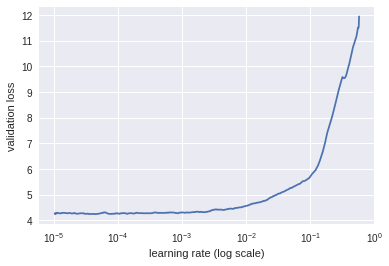

In [64]:
learner.lr_find()
learner.sched.plot()

In [65]:
%time learner.fit(3e-3, 1, wds=1e-6, cycle_len=5)

epoch      trn_loss   val_loss   
    0      4.455862   4.338598  
 17%|█▋        | 781/4583 [03:42<18:02,  3.51it/s, loss=4.42]

    1      4.413214   4.306643  


    2      4.354033   4.266624  


    3      4.310659   4.234794  


    4      4.301601   4.226377  
CPU times: user 44min 12s, sys: 1h 15min 28s, total: 1h 59min 40s
Wall time: 1h 59min 46s


[array([4.22638])]

In [0]:
learner.save_encoder('adam3_10_enc2')
!cp data/aclImdb/models/adam3_10_enc2.h5 drive

In [0]:
!mkdir models
!cp drive/adam3_10_enc2.h5 data/aclImdb/models/
learner.load_encoder('adam3_10_enc2')

In [69]:
learner.lr_find()

 79%|███████▉  | 3618/4583 [17:00<04:32,  3.55it/s, loss=16.9]

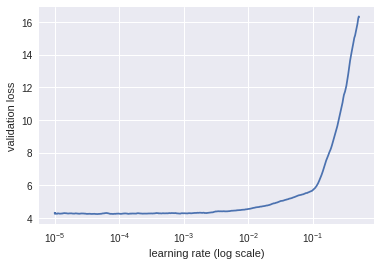

In [71]:
learner.sched.plot(n_skip=1,n_skip_end=10)

In [30]:
%time learner.fit(.001, 1, wds=1e-6, cycle_len=5)

epoch      trn_loss   val_loss   
    0      4.328961   4.249539  
 17%|█▋        | 781/4583 [03:43<18:05,  3.50it/s, loss=4.36]

    1      4.29477    4.238115  


    2      4.256376   4.224548  


    3      4.243876   4.215623  


    4      4.234794   4.213512  

CPU times: user 43min 5s, sys: 1h 16min 16s, total: 1h 59min 21s
Wall time: 1h 59min 32s


[array([4.21351])]

In [0]:
learner.save_encoder('adam3_10_enc3')
!cp data/aclImdb/models/adam3_10_enc3.h5 drive

In [32]:
math.exp(4.165)

64.3926824434624

In [0]:
!cp drive/adam3_10_enc3.h5 data/aclImdb/models/
learner.load_encoder("adam3_10_enc3")

In [38]:
%time learner.fit(.001, 1, wds=1e-6, cycle_len=5)

epoch      trn_loss   val_loss   
    0      4.339206   4.24699   
 17%|█▋        | 781/4583 [03:41<17:58,  3.53it/s, loss=4.36]

    1      4.309587   4.23495   


    2      4.295515   4.221531  


    3      4.261159   4.211912  


    4      4.260031   4.20962   
CPU times: user 42min 7s, sys: 1h 17min 13s, total: 1h 59min 21s
Wall time: 1h 59min 20s


[array([4.20962])]

In [0]:
learner.save_encoder('adam3_10_enc4')
!cp data/aclImdb/models/adam3_10_enc4.h5 drive

In [40]:
%time learner.fit(.001, 1, wds=1e-6, cycle_len=5)

epoch      trn_loss   val_loss   
    0      4.340397   4.242404  
 17%|█▋        | 781/4583 [03:42<18:01,  3.52it/s, loss=4.35]

    1      4.318701   4.232952  


    2      4.309133   4.219536  


    3      4.264636   4.208381  


    4      4.25388    4.206276  
CPU times: user 41min 32s, sys: 1h 17min 38s, total: 1h 59min 11s
Wall time: 1h 59min 32s


[array([4.20628])]

In [0]:
learner.save_encoder('adam3_10_enc5')
!cp data/aclImdb/models/adam3_10_enc5.h5 drive

In [0]:
!cp drive/adam3_10_enc5.h5 data/aclImdb/models/
learner.load_encoder("adam3_10_enc5")

 80%|███████▉  | 3647/4583 [16:34<04:15,  3.67it/s, loss=16.6]

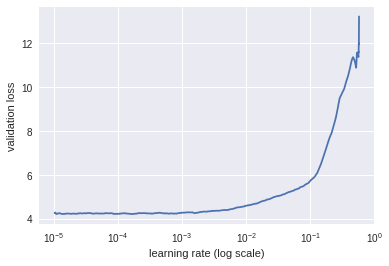

In [43]:
learner.lr_find()
learner.sched.plot()

In [0]:
%time learner.fit(3e-4, 1, wds=1e-6, cycle_len=5)

epoch      trn_loss   val_loss   
    0      4.266714   4.21243   
 17%|█▋        | 781/4583 [03:32<17:14,  3.68it/s, loss=4.26]

    1      4.257501   4.209656  


    2      4.240244   4.206059  


    3      4.242233   4.204436  
 80%|████████  | 3681/4583 [16:43<04:05,  3.67it/s, loss=4.26]

In [0]:
learner.save_encoder('adam3_10_enc6')
!cp data/aclImdb/models/adam3_10_enc6.h5 drive